<a href="https://colab.research.google.com/github/taxfree-python/IWBDA_demo/blob/main/IWBDA_demo_ja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BioCRNpylerの紹介
このノートブックは，BioCRNpylerを使ったさまざまなサンプルモデルの構築について説明します．
パッケージに関するより詳しい情報とリソースは，下を参照してください．

*   [BioCRNpyler Github](https://github.com/BuildACell/BioCRNPyler/)
*   [PLoS Computational Biology](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009987)
*   [BuildACell Video Tutorials on YouTube](https://www.youtube.com/watch?v=lw3DbBnsPgs&list=PLb2LmjoxZO-g2vbTr3HBcnvVZur8JFiqf&index=3)
*   [Extensive example notebooks](https://github.com/BuildACell/BioCRNPyler/tree/master/examples)

**Pypiを使ったBioCRNpylerのインストール(依存ライブラリもまとめて)**

In [1]:
!pip install biocrnpyler[all]
!pip install scipy==1.8.0
!pip install bioscrape

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**SBMLシミュレータとしてBioscrapeをインストールします．SBMLシミュレータなら好きなものを使って構いません．**

**BioCRNpyler Coreの構造図**
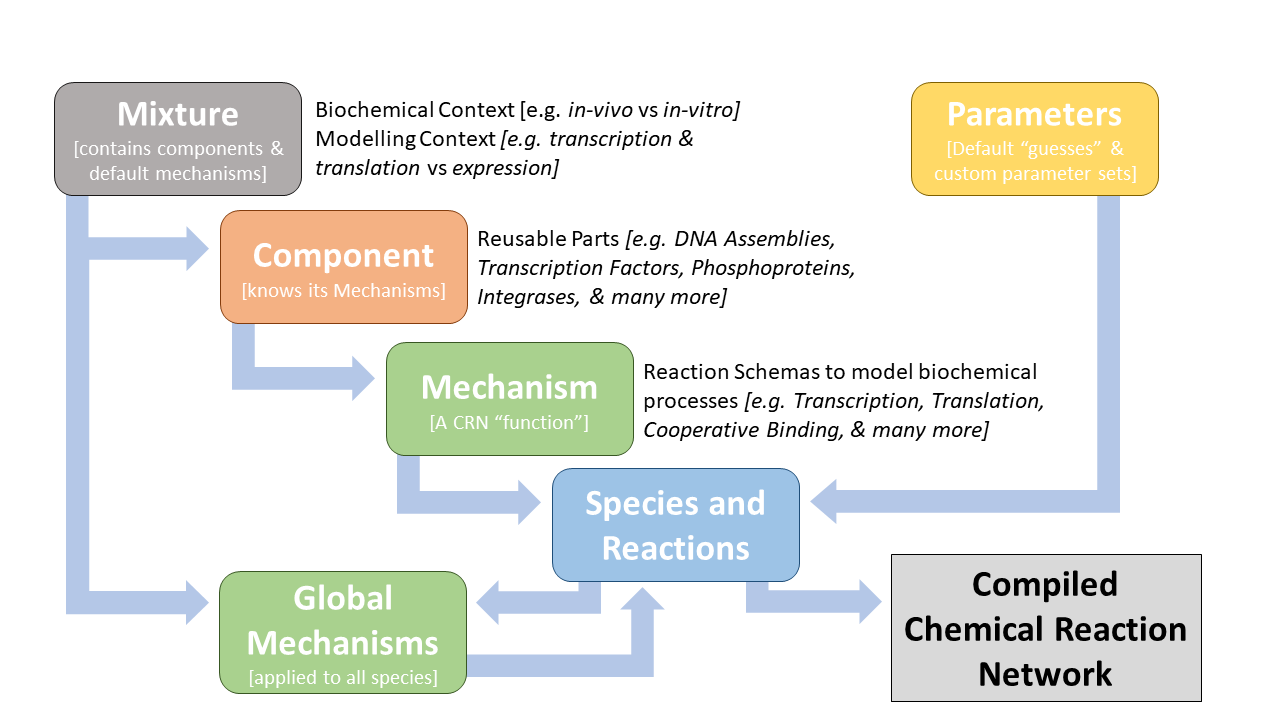

**BioCRNpylerモデルの作成**


1. Mixtureに追加されるComponentとMechanismをインスタンス化します．BioCRNpylerには，酵素や触媒作用，遺伝子制御ネットワークなどのComponentやMechanismがライブラリとして用意されています．なお、Componentは，カスタムしたMechanismsを持つことも，MixtureのMechanismsを利用することも可能です．
2. Mixtureを作成しましょう．ComponentやMechanismがあらかじめ組み込まれた様々なMixtureがありますし，空のMixtureを使用することもできます．
3. パラメータは，dictかパラメータファイルでMixture(もしくは個別のComponent)に追加することができます．パラメータの初期化をすることで，非常に少ないパラメータでモデルをコンパイルすることができ，後から精度を上げるために微調整することができます．
4. CRNにMixtureをコンパイルする．
5. コンパイルしたCRNはSBMLとして保存，プロット，シミュレートすることができます．


In [2]:
from biocrnpyler import *
import pylab as plt
import numpy as np
%matplotlib inline

サンプルモデル : 遺伝子から発現する代謝酵素を作成する

一番簡単なCRNは手で書くことができる


Transcription: $G \to G + T$

Translation: $T \to T + E$

Catalysis: $M_1 + E \to M_2 + E$

In [5]:
#M1とM2は代謝物を表すSpeciesである

M1 = Species("M1")
M2 = Species("M2")
G = Species("G")
T = Species("T")
E = Species("E")

#質量作用の法則が働くReactionで反応速度定数は1.0
r_tx = Reaction.from_massaction([G], [G, T], k_forward = 1.0)
r_tl = Reaction.from_massaction([T], [T, E], k_forward = 1.0)
r_cat = Reaction.from_massaction([M1, E], [M2, E], k_forward = 1.0)

#CRNに保存
CRN = ChemicalReactionNetwork(species = [M1, M2, G, T, E], reactions = [r_tx, r_tl, r_cat])

print(CRN.pretty_print(show_keys = False))

Species(N = 5) = {
T (@ 0),  M2 (@ 0),  M1 (@ 0),  G (@ 0),  E (@ 0),  
}

Reactions (3) = [
0. G --> G+T
 Kf=k_forward * G
  k_forward=1.0

1. T --> T+E
 Kf=k_forward * T
  k_forward=1.0

2. M1+E --> M2+E
 Kf=k_forward * M1 * E
  k_forward=1.0

]


## 同じモデルをMixture，Mechanism，Componentでコンパイルする．

In [33]:
#ComponentとSpeciesを作る
#酵素を作る
E = Enzyme(enzyme = 'E', substrates = [M1], products = [M2])

#DNAアセンブリは転写-翻訳のユニット
G = DNAassembly('G', protein  = E.get_species(), promoter = 'P', rbs = 'RBS')

In [7]:
#いくつかのMechanismを追加する
catalysis = BasicCatalysis()
transcription = SimpleTranscription()
translation = SimpleTranslation()

In [8]:
#パラメータはdictで定義できて，ここではデフォルトの値を使います
parameters = {
    'kcat' : 1.0,
    'ktx' : 1.0,
    'ktl' : 1.0
}

In [30]:
#初期状態の作成(TはGによるのでGとM1だけ与える)
initial_concentrations = {
    G.dna : 1.0,
    M1 : 10.0
}

In [31]:
#Mixtureを作成する
M = Mixture(mechanisms = [catalysis, transcription, translation], components = [G, E], parameters = parameters)

### 一度CRNをコンパイルすると，species, reaction, parameterを出力することができます．

In [11]:
#CRNをコンパイル
CRN = M.compile_crn(initial_concentration_dict = initial_concentrations)

#CRNを出力
print(CRN.pretty_print(pp_show_rates = True, show_keys = True))

#SBMLとしてCRNを保存
CRN.write_sbml_file('my_model.xml')

Species(N = 5) = {
M1 (@ 10.0),  dna[G] (@ 1.0),  M2 (@ 0),  rna[G] (@ 0),  protein[E] (@ 0),  
}

Reactions (3) = [
0. dna[G] --> dna[G]+rna[G]
 Kf=k_forward * dna_G
  k_forward=1.0
  found_key=(mech=None, partid=None, name=ktx).
  search_key=(mech=simple_transcription, partid=P, name=ktx).

1. rna[G] --> rna[G]+protein[E]
 Kf=k_forward * rna_G
  k_forward=1.0
  found_key=(mech=None, partid=None, name=ktl).
  search_key=(mech=simple_translation, partid=RBS, name=ktl).

2. protein[E]+M1 --> protein[E]+M2
 Kf=k_forward * protein_E * M1
  k_forward=1.0
  found_key=(mech=None, partid=None, name=kcat).
  search_key=(mech=basic_catalysis, partid=E, name=kcat).

]


True

### BioCRNpylerはBioscrapeとlibroadrunnerを使って自動的にCRNをシミュレートすることができます．しかし，任意のSBMLシミュレータでCRNモデルをインポートすることができるはずです．

/usr/local/lib/python3.8/dist-packages/html5lib/_trie/_base.py:3: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Mapping


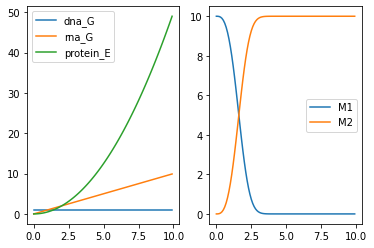

In [12]:
#Bioscrapeを使ったCRNのシミュレーションとプロット

timepoints = np.arange(0, 10, 0.1)
results = CRN.simulate_with_bioscrape_via_sbml(timepoints)

plt.subplot(1, 2, 1)
plt.plot(timepoints, results[str(G.dna)], label = str(G.dna))
plt.plot(timepoints, results[str(G.transcript)], label = str(G.transcript))
plt.plot(timepoints, results[str(G.protein)], label = str(G.protein))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(timepoints, results[str(M1)], label = str(M1))
plt.plot(timepoints, results[str(M2)], label = str(M2))
plt.legend()

### BioCRNpylerは，CRNを可視化するためのインタラクティブなプロット機能を備えています．

In [42]:
from bokeh.plotting import figure, show, output_notebook

plot = render_network_bokeh(CRN,
                            use_pretty_print=True, #uses pretty print
                            pp_show_rates=False, #this would put the reaction rates in the reaction name. It's already listed seperately in the tool tip
                            pp_show_attributes=False,
                            pp_show_material = True, #this lists the material of the species being displayed
    )
output_notebook()
show(plot)

### Mechanismが変わると，より複雑な新しいCRNが生まれます．


In [38]:
catalysis = MichaelisMentenReversible() #E + S <--> E:S --> E + P

rnap = Species('RNAP')
transcription = Transcription_MM(rnap = rnap) #G + RNAP <--> G:RNAP --> G + RNAP + T

ribo = Species('Ribo')
translation = Translation_MM(ribosome = ribo) #T + Ribo <--> T:Ribo --> T + X + Ribo

parameters = {
    "kcat": 1.0,
    "ktx": 1.0,
    "ktl": 1.0,
    "kb": 1.0,
    "ku": 1.0,
}

#Notice that the same Components can be reused, but now we have the new Mechanisms
M = Mixture(mechanisms = [catalysis, transcription, translation], components = [G, E], parameters = parameters)

initial_concentrations = {
    G.dna: 1.0,
    M1: 10.0,
    rnap: 1.0,
    ribo: 5.0
}

CRN = M.compile_crn(initial_concentration_dict = initial_concentrations)

print(CRN.pretty_print(show_keys = False))

ValueError: ignored

In [32]:
import bokeh
bokeh.io.output_notebook() #this makes the graph appear in line with the notebook

plot = render_network_bokeh(CRN,
                            use_pretty_print=True, #uses pretty print
                            pp_show_rates=False, #this would put the reaction rates in the reaction name. It's already listed seperately in the tool tip
                            pp_show_attributes=False,
                            pp_show_material = True, #this lists the material of the species being displayed
                            layout = 'circle'
    )
bokeh.io.show(plot)

/usr/local/lib/python3.8/dist-packages/bokeh/plotting/graph.py:120: UserWarning: Node keys in 'layout_function' don't match node keys in the graph. These nodes may not be displayed correctly.
  warn("Node keys in 'layout_function' don't match node keys in the graph. "


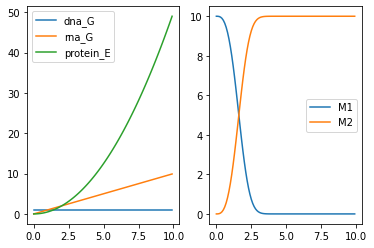

In [43]:
#Bioscrapeを使ったCRNのシミュレーションとプロット

timepoints = np.arange(0, 10, .1)
results = CRN.simulate_with_bioscrape_via_sbml(timepoints)

plt.subplot(1, 2, 1)
plt.plot(timepoints, results[str(G.dna)], label = str(G.dna))
plt.plot(timepoints, results[str(G.transcript)], label = str(G.transcript))
plt.plot(timepoints, results[str(G.protein)], label = str(G.protein))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(timepoints, results[str(M1)], label = str(M1))
plt.plot(timepoints, results[str(M2)], label = str(M2))
plt.legend()